# 1. Micrograd from scratch

The goal of this project is create a simple but effective version of autograd, for implementing backpropagation in a NN
Requirements: math, numpy, matplotlib, graphviz (this one is an API). 

I used: conda install -c conda-forge pygraphviz. I had to uninstall matplotlib and Pillow and reinstall them, Pillow first, so sort out a new error that popped out. Then I had to reinstall jupyter which grant me further issues and errors with missing matplotlib. Currently everything seems to work OK but graphviz.

Update April Fools day: it seems I managed to install it with this instruction:

conda install python-graphviz


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import graphviz

%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x +5

f(3)


20

In [5]:
xs = np.arange(-5, 5, 0.25)

ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

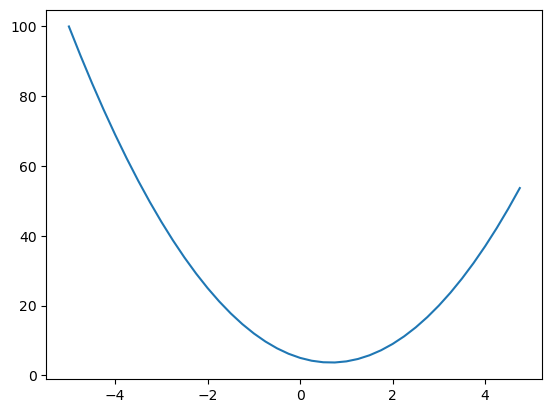

In [6]:
plt.plot(xs, ys)


In [10]:
# obtaining the derivate by the approx formula, we obtain the same number than the derivate itself of f if the increase is small
h= 0.00000000001
x= 3
(f(x +h) - f(x))/h

14.000178794049134

In [12]:
#another example of the same kind
h= 0.00000000001
x= 2/3

(f(x +h) - f(x))/h

8.000000661922968

In [13]:
# a more complex case, inspecting the partial derivates of the three variables. 
# Furthermore, we choose a function, d, that resembles linear regression
a = 2
b= -3
c= 10
d= a*b + c
print(d)

4


In [18]:
# demonstration than the derivate is the slope of the function in a given point"
# partial derivative of d respect to a is equal to b

h = 0.000001
a = 2
b= -3
c= 10
d1= a*b + c
a += h

d2 = a*b + c

print('d1', d1)
print('d2', d2)
print ('slope', (d2 -d1)/h)

d1 4
d2 3.9999969999999996
slope -3.000000000419334


In [19]:
# partial derivative of d respect to b is equal to a

h = 0.0001
a = 2
b= -3
c= 10
d1= a*b + c
b += h

d2 = a*b + c

print('d1', d1)
print('d2', d2)
print ('slope', (d2 -d1)/h)

d1 4
d2 4.0002
slope 2.0000000000042206


In [20]:
# partial derivative of d respect to c is 1, the rate of change of d respect to c.

h = 0.0001
a = 2
b= -3
c= 10
d1= a*b + c
c += h

d2 = a*b + c

print('d1', d1)
print('d2', d2)
print ('slope', (d2 -d1)/h)

d1 4
d2 4.0001
slope 0.9999999999976694


In [33]:
# Now we define the Value object, which will help us to deal with 
# the large data structures the model will work with without 
# doing every single derivate. Value just wraps and keeps track of an scalar.
# __init__ wraps the data
# __repr__ prints the expression with the value of the scalar (makes it legible for us)
# __add__ is necessary to perform a + b because Python does not know how to
#add two Value objets.


#Warning: notice that __init__ has has input 'self, data', not self.data

class Value:
    
    def __init__(self,data):
        self.data=data
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
   #without the following code, python won't perform the sum of Value + Value.

    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    
    
a= Value(2.0)

b= Value(-3.0)
# with the following line, Python does a.__add__(b)


a + b



Value(data=-1.0)

In [35]:
#Now we implement multiply and add c

class Value:
    
    def __init__(self,data):
        self.data=data
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out
    
    
a= Value(2.0)
b= Value(-3.0)
c = Value (10.0)

#equivalent of (a.__mul__(b)).__add__(c)
a*b  + c


Value(data=4.0)

In [38]:
# Now we add more variables to keep track of how calculations are done, which variables lead to other variables
# Children (by default, empty table), and is stored as a set in self._prev


class Value:
    
    def __init__(self,data, _children=()):
        self.data=data
        self._prev = set(_children)
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other))
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other))
        return out
    
    
a= Value(2.0)
b= Value(-3.0)
c = Value (10.0)

d = a*b  + c

d

Value(data=4.0)

In [39]:
# d returns apparently the same info than before, but d._prev gives us
#the two children values, a*b and c
d._prev


{Value(data=-6.0), Value(data=10.0)}

In [99]:
#then we add info of the operation that relates the children
#Adding label
#Adding grad to implement backpropagation later

class Value:
    
    def __init__(self,data, _children=(), _op='', label=''):
        self.data=data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label= label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        return out
    
    #for implementation of hyperbolic tangent
    def tanh(self):
        x= self.data
        #math formula of tanh
        t= (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        return out
    
    
a= Value(2.0, label ='a')
b= Value(-3.0, label ='b')
c = Value (10.0, label ='c')
e = a*b; e.label= 'e'
d = e + c; d.label = 'd'
f= Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [41]:
d._op

'+'

Importing graphviz to create a visual representation of the nodes. Editing the Value class to add labels


In [79]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name= uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot
    

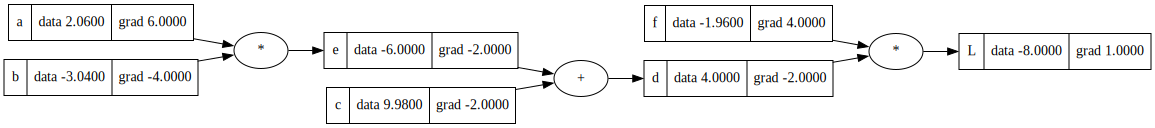

In [80]:
draw_dot(L)
#now we have a representation of the network. We beging with a value of grad = 0, it does not change anything on L, which is itself our cost function by this point.

L = d * f
dL/dd = ?, of course it is f, demostration:

Derivate is the limit (h>>0): (f(x+h) - f(x))/h

and as X = L in this case

((d+h)*f - d*f)/h
(d*f + h*f - d*f)/h
(h*f)/h, which tends to f

and similarly, dL/df is d.

Implement the values for f.grad and d.grad in the next cell, L.grad is obtain from lol()

What is dL/dc?
dd/dc = e = 1
dd/de = also 1

Using chain rule, we can determine than. dL/dc = (dL/dd)*(dd/dc) = -2 * 1. Same applies to dL/de.

What is dL/da? and dL/db? chain rule again

dL/da =  (dL/de)  * (dE/da) = -2 * -3 = 6
dL/db = (dL/de) * (dE/db) = -2 * 2 = -4



In [86]:
#these values represent the derivate of L respecting to the variable:
L.grad = 1.0
f.grad = 4.0
d.grad= -2.0
c.grad = -2.0
e.grad = -2.0
a.grad= 6.0
b.grad= -4.0


In [87]:
#changing our parameters, makes L less negative, it

a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*f.grad

e = a*b
d = e + c
L = d * f

print(L.data)
#everything we run this over and over we are applying gradient

-7.286496


In [108]:
#we define a function to calculate derivates, also partials 

def lol():
    
    h= 0.000001
    
    a= Value(2.0, label ='a')
    b= Value(-3.0, label ='b')
    c = Value (10.0, label ='c')
    e = a*b; e.label= 'e'
    d = e + c; d.label = 'd'
    f= Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    #add h to any variable (Directly to a, b, c , f or L, apply x.data += h after the line for e, d)
    
    a= Value(2.0, label ='a')
    b= Value(-3.0, label ='b')
    c = Value (10.0, label ='c')
    e = a*b; e.label= 'e'
    d = e + c; d.label = 'd'
    f= Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L2 = L.data  
    
    print((L2 - L1)/h)
    
lol()
    
#if you want to do gradient check with every variable, you need to change d to "d.data += h"

1.000000000139778


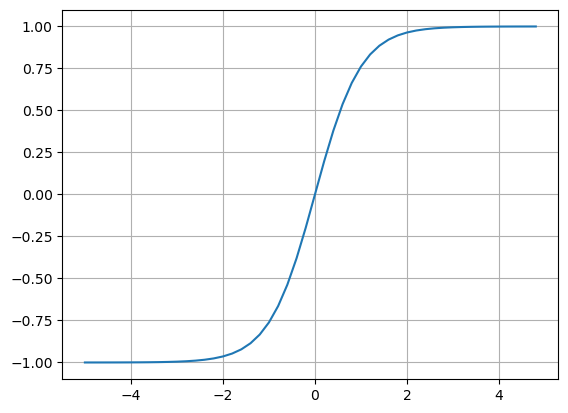

In [89]:
#implement backpropagation in our two-layer NN
# firstly, we plot our activation function using tanh, hyperbolic tangent

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

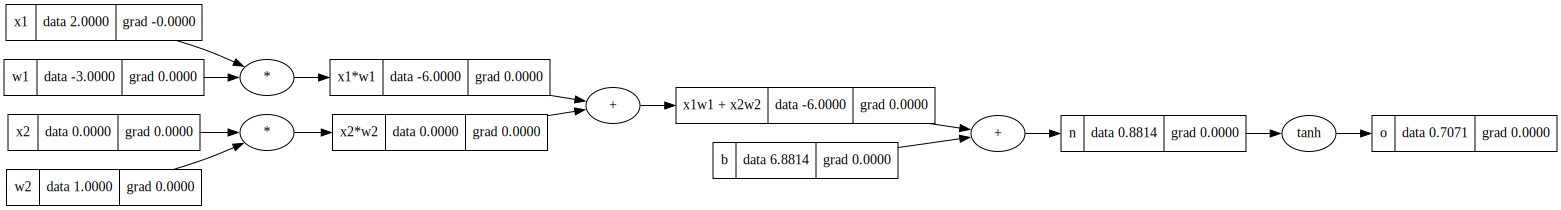

In [128]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights and bias
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813737, label='b')

#inputs * weights and adding the bias
x1w1 = x1 *w1; x1w1.label = 'x1*w1'
x2w2 = x2 *w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#adding activation, need to implement tanh  back to defining Value object
o = n.tanh(); o.label='o'
draw_dot(o)

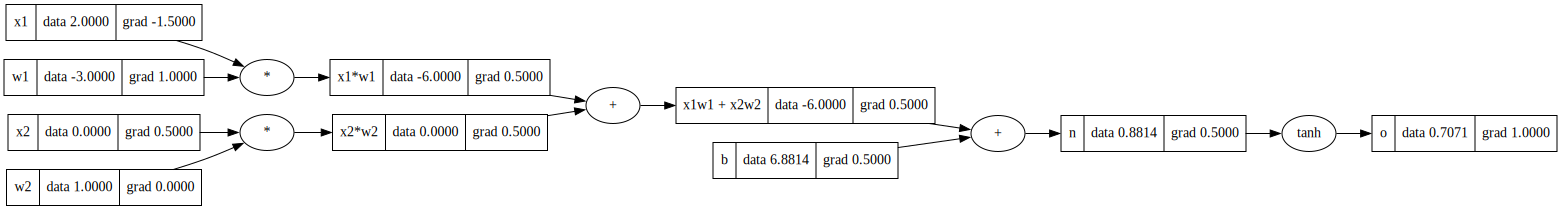

In [130]:
draw_dot(o)

what is do/do?, 1.0
what is do/dn?the actual derivate of hyperbolic targent: 1 - tanh(x)^2, which in this case is approx 0.5 with the original output done by the bias.
We can then obtain the rest following the chain rule

In [129]:
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad= 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad= w1.data * x1w1.grad
w1.grad= x1.data * x1w1.grad



In [117]:
o.data

0.7071068376767715

In [138]:
#updating value class to implement backpropagation in automatic manner

#self._backward is a function that applies chain rule. By default it does not do anything.
#we need to add it every time we create an out Value, to propagate the gradient to the original Values. For example, for __add__, we multiply local 
#derivative times the global derivative  to obtain the grad of the two elements we add, which we know already is the same grad

class Value:
    
    def __init__(self,data, _children=(), _op='', label=''):
        self.data=data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label= label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        #for multiplication, each Value multiplies the other Value times the out grad.
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward    
        return out
    
    #for implementation of hyperbolic tangent
    def tanh(self):
        x= self.data
        #math formula of tanh
        t= (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        #for tanh, the local derivative is the one of tanh
        def _backward():
            self.grad = (1- t**2) * out.grad
        out._backward = _backward
        
        return out
    
    
a= Value(2.0, label ='a')
b= Value(-3.0, label ='b')
c = Value (10.0, label ='c')
e = a*b; e.label= 'e'
d = e + c; d.label = 'd'
f= Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

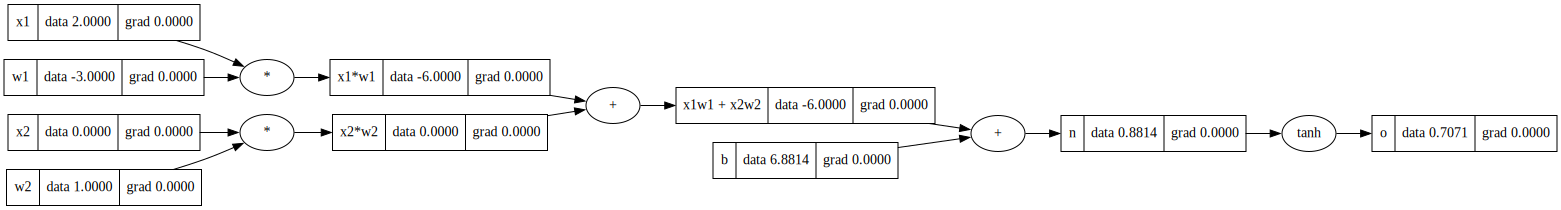

In [152]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights and bias
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813737, label='b')

#inputs * weights and adding the bias
x1w1 = x1 *w1; x1w1.label = 'x1*w1'
x2w2 = x2 *w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#adding activation, need to implement tanh  back to defining Value object
o = n.tanh(); o.label='o'
draw_dot(o)


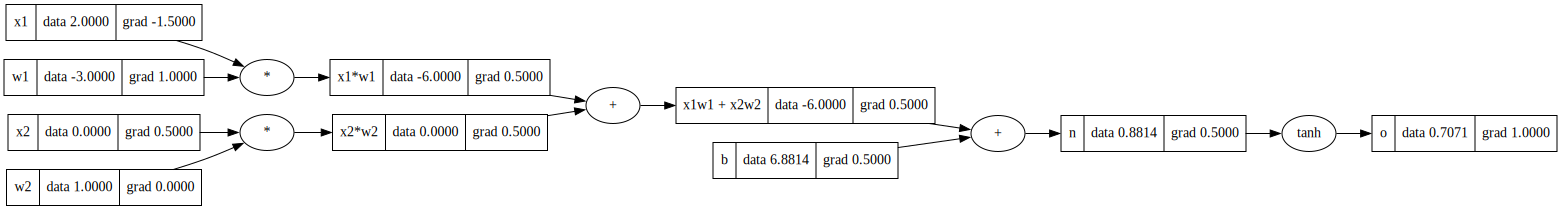

In [156]:
#with the current code, we need to update o.grad (define as 0 in the Value object, self.grad = 0)
#and call for ._backward for every Value. We need to do it backwards in the right order, of course!
o.grad =1.0

o._backward()
n._backward()
b._backward()  #this one does nothing as b is independent
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()
draw_dot(o)


In [161]:
#Now we need to implement grad automatically throughout the whole network. We need a way to be sure that propagation is backwards, that is,
#no Value gets grad until their children have got it. We use for that a new function, build_topo
topo = []
visited= set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
        
build_topo(o)
topo

#the list is disorganised in my output but it seems to work nevertheless

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.8813737),
 Value(data=0.8813737000000001),
 Value(data=0.7071068376767715)]

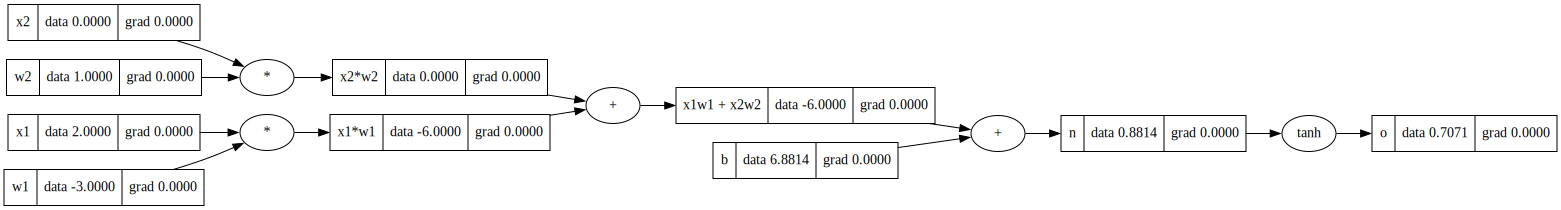

In [162]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights and bias
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813737, label='b')

#inputs * weights and adding the bias
x1w1 = x1 *w1; x1w1.label = 'x1*w1'
x2w2 = x2 *w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#adding activation, need to implement tanh  back to defining Value object
o = n.tanh(); o.label='o'
draw_dot(o)


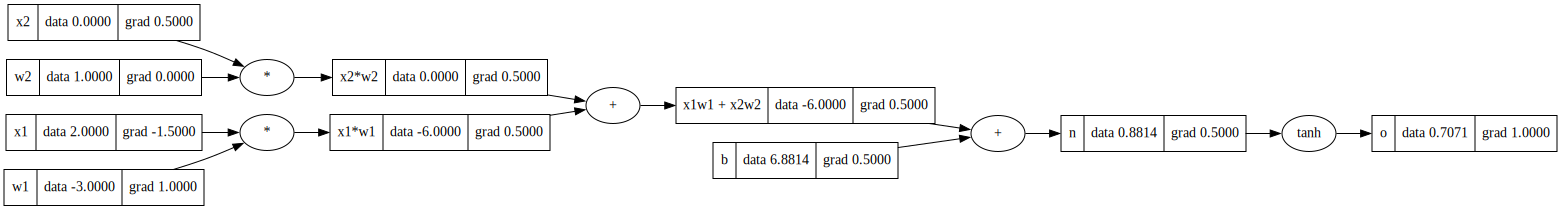

In [164]:
o.grad =1.0

topo = []
visited= set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)     
build_topo(o)

for node in reversed(topo):
    node._backward()
draw_dot(o)

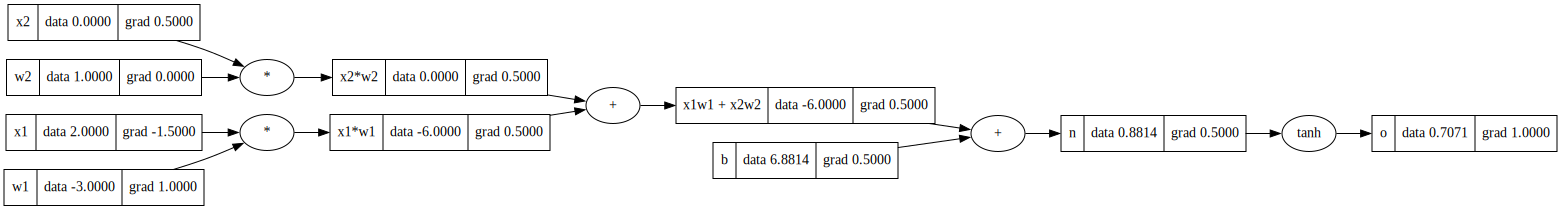

In [182]:
#finally, we add the last code to Value definition

class Value:
    
    def __init__(self,data, _children=(), _op='', label=''):
        self.data=data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label= label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward    
        return out
    
    
    def tanh(self):
        x= self.data
        
        t= (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1- t**2) * out.grad
        out._backward = _backward
        
        return out
    
    #this is the new part now
    def backward(self):

        topo = []
        visited= set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                        build_topo(child)
                topo.append(v)     
        build_topo(self)
          #change o to self to make it universal      
        self.grad =1.0
        for node in reversed(topo):
            node._backward()
    
      
a= Value(2.0, label ='a')
b= Value(-3.0, label ='b')
c = Value (10.0, label ='c')
e = a*b; e.label= 'e'
d = e + c; d.label = 'd'
f= Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
##the next line does all the job now
o._backward()
###
draw_dot(o)

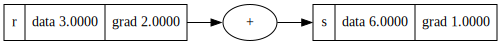

In [185]:
#However, there was a bug in the code that we have not spotted yet, if we try to add a Vale to itself, grad does not work
# if s is r + r, ds/dr should be 2 (1 +1), but the code gives it 1
            
r = Value(3.0, label='r')
s= r + r; s.label= 's'

s.backward()
draw_dot(s)

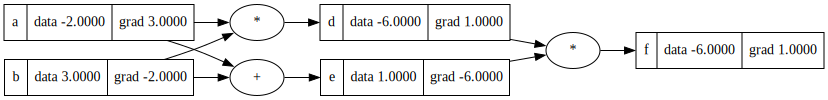

In [183]:
#the problem is in the definition of _add_, as in this case self and other are the same, and we overwrite it
#the error manifests also in this code (re-run definition of value before this code)

a = Value(-2.0, label='a')
b = Value(3.0, label= 'b')
d = a  * b; d.label= 'd'
e = a + b; e.label= 'e'
f = d * e; f.label = 'f'
f.backward()
draw_dot(f)

#gradients of d and e are correct, and those of a and b make sense for the mutiplication to make d, but not the addition to make e

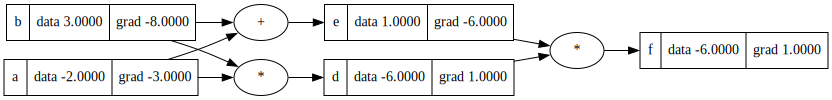

In [184]:
#the solution is to accumulate the gradients, because this is multivariate:

class Value:
    
    def __init__(self,data, _children=(), _op='', label=''):
        self.data=data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label= label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward    
        return out
    
    
    def tanh(self):
        x= self.data
        
        t= (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        
        return out
    
    #this is the new part now
    def backward(self):

        topo = []
        visited= set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                        build_topo(child)
                topo.append(v)     
        build_topo(self)
          #change o to self to make it universal      
        self.grad =1.0
        for node in reversed(topo):
            node._backward()
            
a = Value(-2.0, label='a')
b = Value(3.0, label= 'b')
d = a  * b; d.label= 'd'
e = a + b; e.label= 'e'
f = d * e; f.label = 'f'
f.backward()
draw_dot(f)


In [186]:
#edit _add_ to allow adding numbers, __mult__ to multiply numbers. We edit the code so both other and value

#2 * a won't work if we just change the code to other, we add the function __rmul__ for this that checks if the other way works

#adding also exponential and divide


class Value:
    
    def __init__(self,data, _children=(), _op='', label=''):
        self.data=data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label= label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward    
        return out
    
    def __rmul__ (self, other): #other * self
        return self * other
    
    def tanh(self):
        x= self.data
        
        t= (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x= self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data *out.grad
        out._backward = _backward
        
        
    def backward(self):

        topo = []
        visited= set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                        build_topo(child)
                topo.append(v)     
        build_topo(self)
          #change o to self to make it universal      
        self.grad =1.0
        for node in reversed(topo):
            node._backward()
            

In [187]:
a= Value(2.0)
a.exp()

In [191]:
a + 2

Value(data=4.0)